## Lista 3 - Aprendizagem de máquina probabilístico
- Aluno: Lucas Rodrigues Aragão - Graduação 538390

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sp
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal as mvn
from scipy.special import logsumexp
from sklearn.cluster import KMeans

## Solução MAP para modelos de mistura gaussiana usando Expectation Maximization

1. Escolher os hiperparâmetros $K, \alpha_k, m_0, \kappa_0, \nu_0, S_0 ,\pi^{(0)}_k, \mu_k^{(0)}, \Sigma^{(0)}_{k}, \space \forall_k$

Valores comuns: $S_0 = \frac{1}{K^{2/D}} S_{\bar{x}}$, $\nu_0 = D+2$, $m_0 = \bar{x}$ e $\kappa_0 = 0.01$. Em que $\bar{x}$ é a média amostral e $S_{\bar{x}}$ é a covariância amostral.

### Expectation

$$r_{ik} \triangleq p(z_i = k| x_i, \theta^{(t-1)}) = \frac{\pi_k^{(t-1)} \mathcal{N}(x_i| \mu_k^{(t-1)}, \Sigma_{k}^{(t-1)})}{\sum^{K}_{k'} \pi^{(t-1)}_{k'} \mathcal{N}(x_i| \mu_{k'}^{(t-1)}, \Sigma_{k'}^{(t-1)})} $$

### Maximization

$$\pi_k^{(t)} = \frac{\alpha_k - 1 + \Sigma_i r_{ik}}{N-K + \sum_k \alpha_k}$$

$$\bar{x_k} \triangleq \frac{\Sigma_i r_{ik}x_i}{\Sigma_i r_{ik}}$$

$$\mu_k^{(t)} = \frac{\kappa_0m_0 + \bar{x}_k \Sigma_i r_{ik}}{\kappa_0 + \Sigma_i r_{ik}}$$

$$\Sigma_k^{(t)} = \frac{S_0 + \sum_i r_{ik} (x_i - \bar{x}_k) (x_i - \bar{x}_k)^T + \frac{\kappa_0 \sum_i r_{ik}}{\kappa_0 + \sum_i r_{ik}} (\bar{x}_k - m_0) (\bar{x}_k -m_0)^T}{\nu_0 + D + 2 + \sum_i r_{ik}}$$


In [2]:
class EmGMM():
    def __init__(self, K, alpha, m0, k0, nu0, s0, pi0, mu0k, sigma0):
        self.K = K
        self.alpha = alpha
        self.m0 = m0 
        self.kappa = k0
        self.nu = nu0
        self.S0 = s0
        self.pi = pi0 
        self.mu = mu0k
        self.sigma = sigma0
        self.log_likelihood_history = []        


    def expectation(self, xi, index):
        K = self.K
        responsibility_sum = np.sum([
            self.pi[k] * mvn.pdf(xi, mean=self.mu[k], cov=self.sigma[k])
            for k in range(K)
        ])
        for k in range(K):
            num = self.pi[k] * mvn.pdf(xi, mean=self.mu[k], cov=self.sigma[k])
            self.responsabilities[index, k] = num / responsibility_sum

    def maximizationMAP(self, X, N):
        K = self.K
        D = X.shape[1]

        for k in range(K):
            r_k = self.responsabilities[:, k]
            r_sum = np.sum(r_k)

            x_bar_k = np.sum(r_k[:, None] * X, axis=0) / r_sum

            self.pi[k] = (self.alpha[k] - 1 + r_sum)/(N - K + np.sum(self.alpha))
            self.mu[k] = (self.kappa * self.m0 + x_bar_k * r_sum)/(self.kappa + r_sum)

            diff_i = X - x_bar_k
            diff_k = x_bar_k - self.m0

            term2 = diff_i.T @ (r_k[:, None] * diff_i)  
            term3 = ((self.kappa * r_sum) / (self.kappa + r_sum)) * diff_k @ diff_k.T
            
            self.sigma[k] = (self.S0 + term2 + term3) / (self.nu + D + 2 + r_sum) + np.eye(D) *10e-3

    def log_likelihood(self, X):
        X = np.atleast_2d(X)
        if X.shape[0] < X.shape[1]:
            X = X.T
        N, D = X.shape
        K = self.K
        pdfs = np.zeros((N, K))
        for k in range(K):
            pdfs[:, k] = self.pi[k] * mvn.pdf(X, mean=self.mu[k], cov=self.sigma[k], allow_singular=True)
        row_sums = np.sum(pdfs, axis=1)
        return np.sum(np.log(row_sums + 1e-12))


    def train(self, X ,epochs, responsabilities_init=None):
        N = X.shape[0] 
        
        if responsabilities_init is not None:
            self.responsabilities = responsabilities_init.copy()
        else:
            self.responsabilities = np.random.rand(N, self.K)
            self.responsabilities /= self.responsabilities.sum(axis=1, keepdims=True)
        
        ll = self.log_likelihood(X)
        self.log_likelihood_history.append(ll)  

        for _ in range(epochs):
            for j, xi in enumerate(X):
                self.expectation(xi, j)
            self.maximizationMAP(X, N)
            ll = self.log_likelihood(X)
            self.log_likelihood_history.append(ll)        

## Métricas de avaliação

Sejam M o número de parâmetros do modelo , N o total de obsevações e K o número de centroídes do modelo;

M é dado por: $M = K-1 + K \times D + K \times D \times (D+1)/2$

### Bayesian Information Criterion

$$BIC(D,K) \triangleq \log p(D|\hat{\theta}) - \frac{1}{2} M \log N $$

### Akaike Information Criterion

$$AIC(D,K) \triangleq \log p(D|\hat{\theta}) - M$$

In [3]:
def evaluate(self, X, bic = True, aic = True, ll = True):
    # M = k-1 + k * D + K * D * (D+1)/2
    K = self.K
    D = X.shape[1]
    M = (K - 1) + K * D + K * D * (D + 1) / 2

    if bic == True:
        bic = self.log_likelihood(X) - (1/2  * M * np.log(X.shape[0]))
    if aic == True:
        aic = self.log_likelihood(X) - M
    if ll == True:
        ll = self.log_likelihood(X)
    return bic, aic, ll

EmGMM.evaluate = evaluate

## Questão 1

In [4]:
data = pd.read_csv("clustering_data.csv", header= None)
data = data.astype(float)
data_train, data_val = train_test_split(data, test_size= 0.2)

In [5]:
data

,0,1
0,-9.324269,-8.524550
1,-4.802893,4.568391
2,-9.151913,-7.235600
3,6.631406,6.885714
4,5.800550,7.154082
...,...,...
95,2.681695,0.991633
96,4.537232,9.209128
97,6.648542,4.320721
98,11.841266,-4.693716


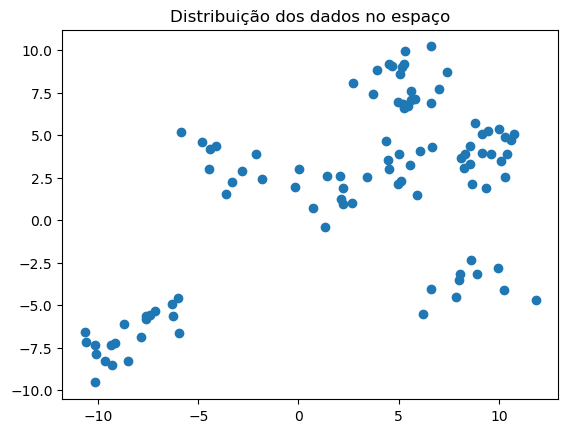

In [6]:
plt.scatter(data[0], data[1])
plt.title("Distribuição dos dados no espaço")
plt.show()

### Testar para os 15 Ks

In [7]:
bics = []
aics = []
lls_train = []
lls_val = []

D = data_train.shape[1]
m0 = data_train.mean(axis=0)
Sx = np.cov(data_train, rowvar=False)
k0 = 0.01
nu0 = D + 2

for k in range(1, 16):
    S0 = Sx / (k ** (2.0 / D))
    alpha = np.ones(k)            
    pi0 = np.ones(k) / k          
    
    km = KMeans(n_clusters=k, random_state=0).fit(data_train)
    mu0k = km.cluster_centers_
        
    responsabilities_init = np.zeros((data_train.shape[0], k))
    responsabilities_init[np.arange(data_train.shape[0]), km.labels_] = 1.0

    sigma0 = np.array([Sx + np.eye(D)*1e-6 for _ in range(k)])

    model = EmGMM(K=k, alpha=alpha, m0=m0, k0=k0, nu0=nu0, s0=S0,
                  pi0=pi0, mu0k=mu0k, sigma0=sigma0)
    
    model.train(X=data_train, epochs=30, responsabilities_init= responsabilities_init)
    bic, aic, ll_train =  model.evaluate(data_train)
    bics.append(bic)
    aics.append(aic)
    lls_train.append(ll_train)

    _, _, ll_val = model.evaluate(data_val, bic= False, aic= False)
    lls_val.append(ll_val)
    print(f"K = {k}, BIC = {bic}, AIC = {aic}, LOGLL-TRAIN = {ll_train}, LOGLL-VAL = {ll_val}")

K = 1, BIC = -504.7419186607819, AIC = -498.78685207409717, LOGLL-TRAIN = -493.78685207409717, LOGLL-VAL = -125.24124424276489
K = 2, BIC = -466.58119034987027, AIC = -453.4800438591639, LOGLL-TRAIN = -442.4800438591639, LOGLL-VAL = -120.4483999354219
K = 3, BIC = -475.19475347343194, AIC = -454.94752707870396, LOGLL-TRAIN = -437.94752707870396, LOGLL-VAL = -115.71888913202864
K = 4, BIC = -472.68275839064813, AIC = -445.2894520918985, LOGLL-TRAIN = -422.2894520918985, LOGLL-VAL = -109.25138391900478
K = 5, BIC = -480.29983240014207, AIC = -445.7604461973708, LOGLL-TRAIN = -416.7604461973708, LOGLL-VAL = -113.23750428134656
K = 6, BIC = -470.3183057237155, AIC = -428.63283961692264, LOGLL-TRAIN = -393.63283961692264, LOGLL-VAL = -105.81463797433356
K = 7, BIC = -480.58365146191215, AIC = -431.7521054510976, LOGLL-TRAIN = -390.7521054510976, LOGLL-VAL = -109.12787564805767
K = 8, BIC = -489.1373694578386, AIC = -433.1597435430024, LOGLL-TRAIN = -386.1597435430024, LOGLL-VAL = -109.78743

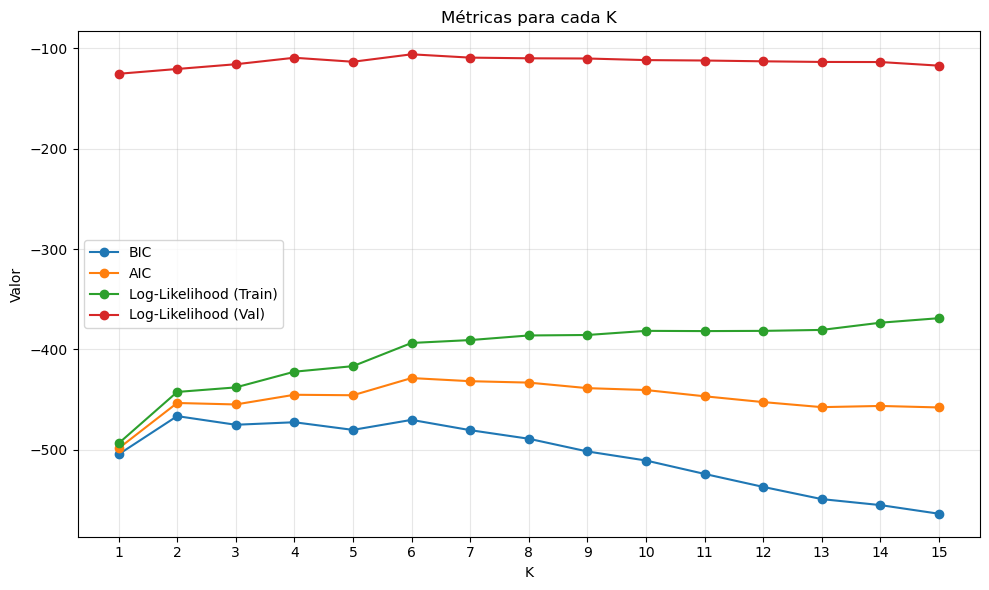

In [8]:
Ks = np.arange(1, 16)

plt.figure(figsize=(10,6))

plt.plot(Ks, bics, marker='o', label='BIC', color='tab:blue')
plt.plot(Ks, aics, marker='o', label='AIC', color='tab:orange')
plt.plot(Ks, lls_train, marker='o', label='Log-Likelihood (Train)', color='tab:green')
plt.plot(Ks, lls_val, marker='o', label='Log-Likelihood (Val)', color='tab:red')

plt.title("Métricas para cada K")
plt.xlabel("K")
plt.xticks(ticks=[i for i in range (1,16)])
plt.ylabel("Valor")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


### Gerar visualização para o melhor K de cada métrica

In [9]:
def treinao(X, k):
    D = X.shape[1]
    m0 = X.mean(axis=0)
    Sx = np.cov(X, rowvar=False)
    k0 = 0.01
    nu0 = D + 2
    S0 = Sx / (k ** (2.0 / D))
    alpha = np.ones(k)            
    pi0 = np.ones(k) / k          

    km = KMeans(n_clusters=k, random_state=0).fit(X)
    mu0k = km.cluster_centers_

    responsabilities_init = np.zeros((X.shape[0], k))
    responsabilities_init[np.arange(X.shape[0]), km.labels_] = 1.0

    sigma0 = np.array([Sx + np.eye(D)*1e-6 for _ in range(k)])

    model = EmGMM(K=k, alpha=alpha, m0=m0, k0=k0, nu0=nu0, s0=S0,
                    pi0=pi0, mu0k=mu0k, sigma0=sigma0)

    model.train(X=X, epochs=20, responsabilities_init= responsabilities_init)
    return model

In [10]:
def plot_clusters(X, responsibilities, mu):
    labels = np.argmax(responsibilities, axis=1)
    K = responsibilities.shape[1]

    plt.figure(figsize=(6,4))
    for k in range(K):
        mask = labels == k
        plt.scatter(X.iloc[mask, 0], X.iloc[mask, 1], s=30, label=f'Cluster {k}')
        plt.scatter(mu[k][0], mu[k][1], marker='X', c='black', s=50)
    plt.title("Clusters (hard assignments)")
    plt.show()

#### BIC: K = 5

In [11]:
modelbic = treinao(data, 5)
modelbic.mu

array([[-8.37145015, -6.66679661],
       [ 8.09167883,  3.721572  ],
       [-1.29786496,  1.99104826],
       [ 8.62327486, -3.7840499 ],
       [ 5.25771178,  7.92382796]])

[-631.2483191469772, -510.7248366390432, -510.2553114197945, -511.1198445567593, -511.18288829317834, -511.1849021711187, -511.18496193525914, -511.1849637010452, -511.1849637532014, -511.18496375474183, -511.18496375478736, -511.18496375478867, -511.1849637547887, -511.1849637547887, -511.1849637547887, -511.1849637547887, -511.1849637547887, -511.1849637547887, -511.1849637547887, -511.1849637547887, -511.1849637547887]


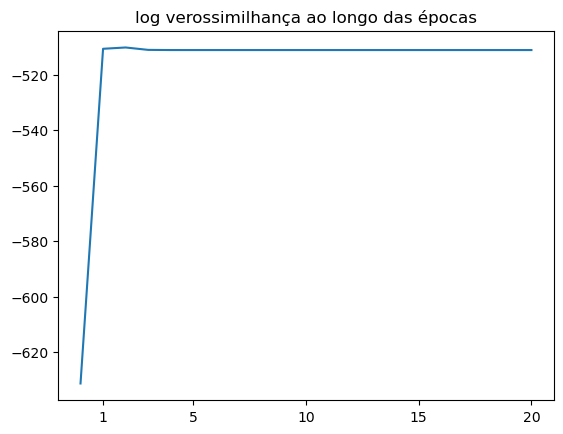

In [12]:
print(modelbic.log_likelihood_history)
plt.plot(modelbic.log_likelihood_history)
plt.title("log verossimilhança ao longo das épocas")
plt.xticks([1,5,10,15,20])
plt.show()

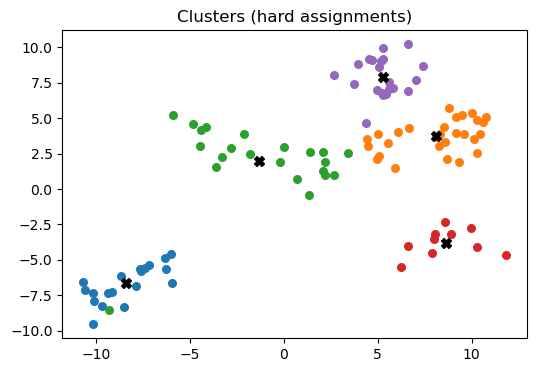

In [13]:
plot_clusters(X=data, responsibilities= modelbic.responsabilities, mu= modelbic.mu)

#### AIC: K = 11

In [14]:
modelaic = treinao(data, k = 6)
modelaic.mu

array([[-8.37145015, -6.66679661],
       [ 2.50992825,  1.8751957 ],
       [-2.96980316,  3.14393469],
       [ 8.62327486, -3.7840499 ],
       [ 5.30114341,  8.08728275],
       [ 9.25358766,  4.02628753]])

[-631.5914627688541, -502.72371370237045, -496.87821665704024, -496.69660188988445, -496.6759045331214, -496.67276508468893, -496.67227350883206, -496.67219612175126, -496.67218392862395, -496.6721820072142, -496.67218170442953, -496.6721816567151, -496.6721816491961, -496.67218164801125, -496.6721816478245, -496.672181647795, -496.67218164779035, -496.67218164778967, -496.67218164778956, -496.67218164778956, -496.6721816477896]


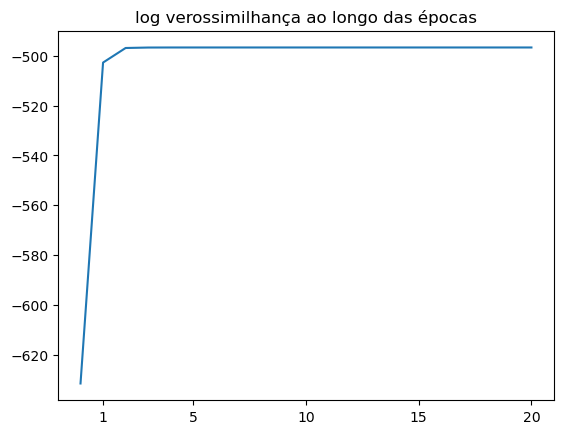

In [15]:
print(modelaic.log_likelihood_history)
plt.plot(modelaic.log_likelihood_history)
plt.title("log verossimilhança ao longo das épocas")
plt.xticks([1,5,10,15,20])
plt.show()

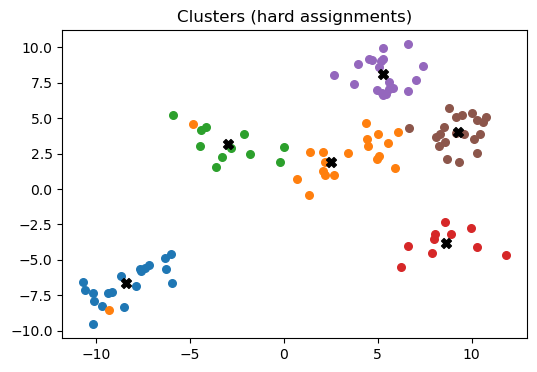

In [16]:
plot_clusters(X=data, responsibilities= modelaic.responsabilities, mu= modelaic.mu)

#### Log verossimilhança validação: K = 5

In [17]:
modelLL = treinao(data, 5)
modelLL.mu

array([[-8.37145015, -6.66679661],
       [ 8.09167883,  3.721572  ],
       [-1.29786496,  1.99104826],
       [ 8.62327486, -3.7840499 ],
       [ 5.25771178,  7.92382796]])

[-631.2483191469772, -510.7248366390432, -510.2553114197945, -511.1198445567593, -511.18288829317834, -511.1849021711187, -511.18496193525914, -511.1849637010452, -511.1849637532014, -511.18496375474183, -511.18496375478736, -511.18496375478867, -511.1849637547887, -511.1849637547887, -511.1849637547887, -511.1849637547887, -511.1849637547887, -511.1849637547887, -511.1849637547887, -511.1849637547887, -511.1849637547887]


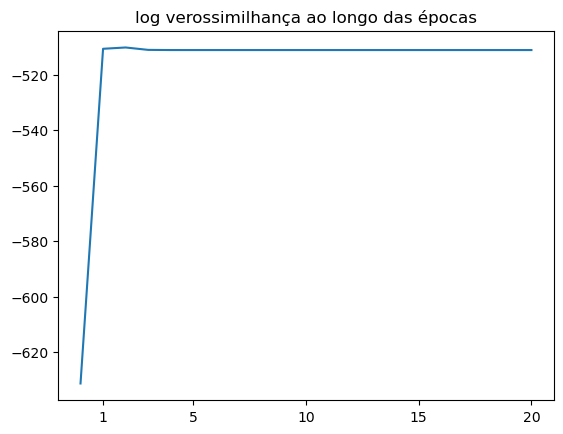

In [18]:
print(modelLL.log_likelihood_history)
plt.plot(modelLL.log_likelihood_history)
plt.title("log verossimilhança ao longo das épocas")
plt.xticks([1,5,10,15,20])
plt.show()

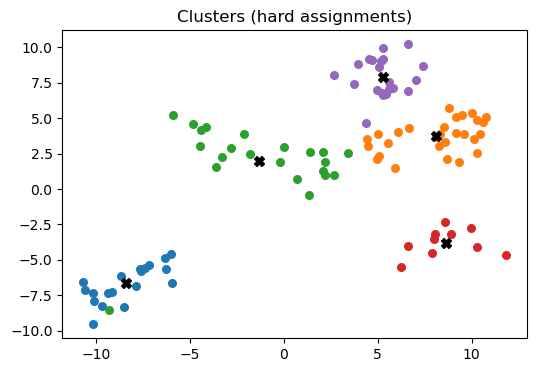

In [19]:
plot_clusters(X=data, responsibilities= modelLL.responsabilities, mu= modelLL.mu)